# EP1
## Cálculo do Conjunto de Mandelbrotem Paralelo com Pthreads e OpenMP

Nesse EP temos apenas quatro membros pois um trancou a materia:

| Nome | NUSP |
|------|------|
| Daniel Hotta | 9922700 |
| Matheus Laurentys | 9793714 |
| Pedro Gigeck | 10737136 |
| Rafael Gonçalves | 9009600 |


## Configuração do Ambiente

O ambiente será herdado do miniEP3

In [2]:
] up

   Updating registry at `~/.julia/registries/General`
   Updating git-repo `https://github.com/JuliaRegistries/General.git`


Fetching: [========================================>]  100.0 %.0 % [==========>                              ]  24.6 %40.7 %54.0 % [==============================>          ]  73.3 % [===================================>     ]  85.8 %]  96.1 %

  Installed SpecialFunctions ─ v0.10.3
  Installed DataFrames ─────── v0.21.1
   Updating `~/Documentos/mac-0219/EP1/src/Project.toml`
  [a93c6f00] ↑ DataFrames v0.21.0 ⇒ v0.21.1
   Updating `~/Documentos/mac-0219/EP1/src/Manifest.toml`
  [324d7699] ↑ CategoricalArrays v0.8.0 ⇒ v0.8.1
  [a93c6f00] ↑ DataFrames v0.21.0 ⇒ v0.21.1
  [91a5bcdd] ↑ Plots v1.2.6 ⇒ v1.3.2
  [276daf66] ↑ SpecialFunctions v0.10.2 ⇒ v0.10.3
  [4c63d2b9] ↑ StatsFuns v0.9.4 ⇒ v0.9.5
  [8f1865be] ↑ ZeroMQ_jll v4.3.2+2 ⇒ v4.3.2+3
  [83775a58] ↑ Zlib_jll v1.2.11+9 ⇒ v1.2.11+10


In [3]:
] st

Status `~/Documentos/mac-0219/EP1/src/Project.toml`
  [336ed68f] CSV v0.6.2
  [a93c6f00] DataFrames v0.21.0
  [31c24e10] Distributions v0.23.2
  [7073ff75] IJulia v1.21.2
  [8314cec4] PGFPlotsX v1.2.6
  [1a8c2f83] Query v0.12.2
  [f3b207a7] StatsPlots v0.14.6



## Medição do tempo

Para medir o tempo de execução geral, usamos o script `run_measurements.sh`, com o comando `perf`, que foi passado no enunciado.

As implementações paralelas (Pthreads e OpenMP) foram executadas com o número fixo de 16 threads.
Além disso o tamanho dos testes foi reduzido para 9, pois o tempo de rodar a sequência com 2^10 foi muito grande.

Para medir o tempo de execução descontando as operações de I/O e alocação de memória, usamos a opção do perf que separa o tempo de execução por cada comando específico do código, assim conseguimos obter o tempo gasto por cada função.

## Sobre as Implementações

A implementação sequencial `mandelbrot_seq.c` foi mantida intacta.

A implementação com OpenMP `mandelbrot_omp.c` foi bastante simples, o cálculo é igual ao sequêncial, porém o for externo foi trocado por um for paralelo do omp, compartilhando a váriavel `i_y`. Dessa forma, cada thread cuida de um intervalo de valores do `i_y`.

A implementação com Pthreads `mandelbrot_pth.c` seguiu a mesma lógica da com OMP, paralelizando o for externo. Cada thread recebe um `i_y` inicial e um `i_y` final e calcula as linhas esquivalentes a esse intervalo. A diferença é que as estruturas das threads e a divisão dos intervalos foram feitos explicitamente.

## Executando

O primeiro passo é compilar todo o codigo deste EP

In [4]:
; make

make: Nothing to be done for 'all'.


In [ ]:
Podemos rodar qualquer uma das implementações para observar as imagens, por exemplo

In [4]:
; ./mandelbrot_seq -2.5 1.5 -2.0 2.0 11500

usage: ./mandelbrot_seq c_x_min c_x_max c_y_min c_y_max image_size
examples with image_size = 11500:
    Full Picture:         ./mandelbrot_seq -2.5 1.5 -2.0 2.0 11500
    Seahorse Valley:      ./mandelbrot_seq -0.8 -0.7 0.05 0.15 11500
    Elephant Valley:      ./mandelbrot_seq 0.175 0.375 -0.1 0.1 11500
    Triple Spiral Valley: ./mandelbrot_seq -0.188 -0.012 0.554 0.754 11500


Por fim, rodamos os scripts com os experimentos

In [ ]:
; ./run_measurements.sh

  Resolving package versions...
   Updating `~/Documentos/mac-0219/EP1/src/Project.toml`
 [no changes]
   Updating `~/Documentos/mac-0219/EP1/src/Manifest.toml`
 [no changes]


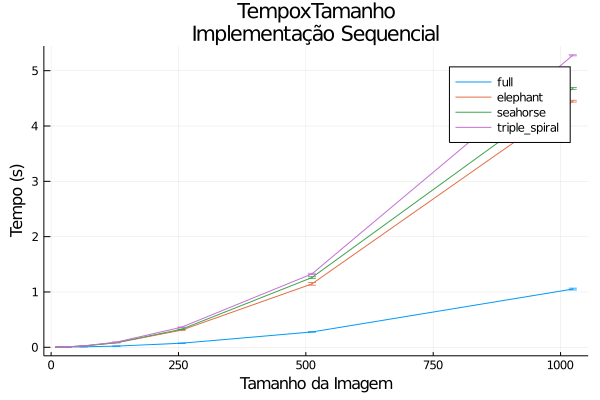

In [54]:
# Gerando o gráfico da implementação sequencial

import Pkg
Pkg.add("Plots")
using DataFrames, Plots

# Get os tempos de execução do log e salva numa string
function get_log_string(log)
    out = Pipe()
    cmd = pipeline(`grep '.seconds time elapsed.' results2/mandelbrot_seq/$log.log`,
          pipeline(`awk '{print $1}'`; stdout=out))
    
    run(cmd)
    close(out.in)
    s = read(out, String)
    return s
end

function get_log_deviation(log)
    out = Pipe()
    cmd = pipeline(`grep '.seconds time elapsed.' results2/mandelbrot_seq/$log.log`,
          pipeline(`awk '{print $3}'`; stdout=out))
    
    run(cmd)
    close(out.in)
    s = read(out, String)
    return s
end

# Transforma a string com os dados em um DataFrame
function get_data_frame()
    logs = ["full", "elephant", "seahorse", "triple_spiral"];
    df = DataFrame()
    df.sz = [2 ^ x for x in 4:10]
    for l in logs
        s = get_log_string(l)
        d = get_log_deviation(l)
        sp = split(s, '\n')
        dsp = split(d, '\n') 
        pop!(sp)
        pop!(dsp)
        times = []
        for t in sp
            push!(times, parse(Float64, replace(t, ","=>".")))
        end
        
        
        deviation = []
        for dv in dsp
            push!(deviation, parse(Float64, replace(dv, ","=>".")))
        end
        df[!, "$l"] = times
        df[!, "dv$l"] = deviation
    end
    return df
end

# Função para plotar o DataFrame
function plot_data_frame(df)
    xs = df.sz
    ys = [df.full df.elephant df.seahorse df.triple_spiral]
    deviation = [df.dvfull df.dvelephant df.dvseahorse df.dvtriple_spiral]
    labels = ["full" "elephant" "seahorse" "triple_spiral"] 
    plot(xs, ys, label = labels, yerror = deviation, 
         xlabel = "Tamanho da Imagem", ylabel = "Tempo (s)", title = "Tempo x Tamanho\nImplementação Sequencial")
end
df = get_data_frame()
plot_data_frame(df)

  Resolving package versions...
   Updating `~/Documentos/mac-0219/EP1/src/Project.toml`
 [no changes]
   Updating `~/Documentos/mac-0219/EP1/src/Manifest.toml`
 [no changes]


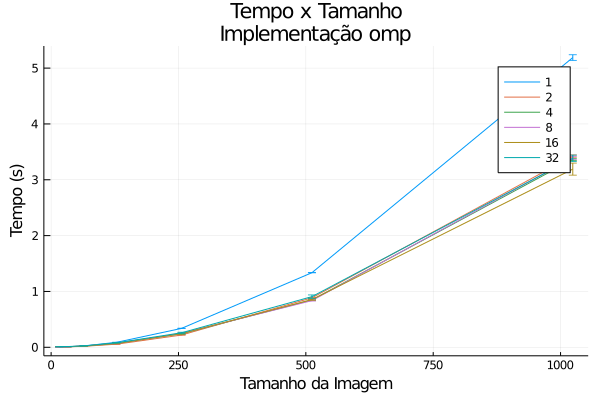

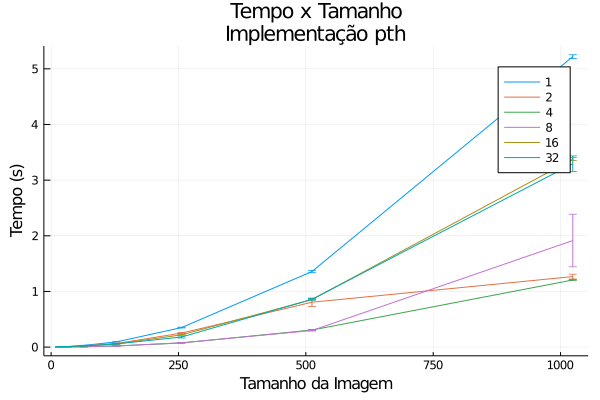

In [55]:
# Gerando o gráfico da implementação paralela

import Pkg
Pkg.add("Plots")
using DataFrames, Plots

# Pega os dados que queremos do log e salva numa string 
function get_log_string(log, implementation, th)
    out = Pipe()
    cmd = pipeline(`grep '.seconds time elapsed.' results2/mandelbrot_$implementation/$log$th.log`,
          pipeline(`awk '{print $1}'`; stdout=out))
    
    run(cmd)
    close(out.in)
    s = read(out, String)
    return s
end

function get_log_deviation(log, implementation, th)
    out = Pipe()
    cmd = pipeline(`grep '.seconds time elapsed.' results2/mandelbrot_$implementation/$log$th.log`,
          pipeline(`awk '{print $3}'`; stdout=out))
    
    run(cmd)
    close(out.in)
    s = read(out, String)
    return s
end

# Transforma a string com os dados em um DataFrame
function get_data_frame(implementation)
    df = DataFrame()
    df.sz = [2 ^ x for x in 4:10]
    th = [2 ^ x for x in 0:5]
    for t in th
        s = get_log_string("triple_spiral", implementation, string(t))
        d = get_log_deviation("triple_spiral", implementation, string(t))
        sp = split(s, '\n')
        dsp = split(d, '\n') 
        pop!(sp)
        pop!(dsp)
        times = []
        for t in sp
            push!(times, parse(Float64, replace(t, ","=>".")))
        end
        deviation = []
        for dv in dsp
            push!(deviation, parse(Float64, replace(dv, ","=>".")))
        end
        df[!, "t$t"] = times
        df[!, "dv$t"] = deviation
    end
    return df
end

# Função para plotar o DataFrame
function plot_data_frame(df, i)
    xs = df.sz
    ys = [df.t1 df.t2 df.t4 df.t8 df.t16 df.t32]
    deviation = [df.dv1 df.dv2 df.dv4 df.dv8 df.dv16 df.dv32]
    labels = ["1" "2" "4" "8" "16" "32"]
    display(plot(xs, ys, label = labels, yerror = deviation, 
         xlabel = "Tamanho da Imagem", ylabel = "Tempo (s)", title = "Tempo x Tamanho\nImplementação $i"))
end

implementations = ["omp" "pth"]
for i in implementations
    df = get_data_frame(i)
    plot_data_frame(df, i)
end

# A partir daqui ta igual ao miniep3
## Não apaguei pq da pra chupinhar os plots

## Exercício 2: Implementação Paralela com *pthreads*

Este exercício é mais complexo. Vocês devem escrever a função de assinatura:

```C
void *monte_carlo_integrate_thread(void *args)
```

Na assinatura acima, o parâmetro `args` é um ponteiro para uma estrutura de dados contendo dados para cada thread. Para implementar essa estrutura de dados, vocês devem decidir quais informações cada thread deve receber. Algumas ideias:

- Um ponteiro para a função a ser avaliada
- Um ponteiro para o vetor de amostras gerado
- Um inteiro com o id da thread

De acordo com a sua estratégia de implementação paralela, vocês vão precisar incluir informações diferentes. Algo de importante está faltando na lista acima. Como as threads poderiam armazenar seus resultados?

Precisamos escolher uma dentre as várias formas de implementar esse algoritmo paralelo. Pensei em algumas possibilidades:

1. Método "Criando threads dinamicamente":
  - Lançar $n$ threads, cada uma com $1$ (ou $m$?) unidades de trabalho a fazer
  - Usar variáveis de condição ou joins para sinalizar fim de trabalho
  - Lançar novas threads conforme threads terminarem
  - Usar join para finalizar
2. Método "Divisão Dinâmica do Trabalho":
  - Lançar $n$ threads, cada uma com $1$ (ou $m$?) unidades de trabalho a fazer
  - Cada thread busca por trabalho disponível a fazer quando acabar o trabalho dado
  - Usar join para finalizar
3. Método "Divisão Estática do Trabalho":
  - Lançar $n$ threads, cada uma com $1/n$ unidades de trabalho a fazer
  - Usar join para finalizar
  
Usando seus conhecimentos sobre *pthreads* e sobre a execução de programas em geral, responda e explique:

1. Qual desses métodos é o mais difícil de implementar? E o mais fácil?

O método 1 parece ser o mais difícil de implementar, enquanto o método 3 parece ser o mais simples. O método 1 exige alguma forma de comunicação entre as threads que permita a alguma thread saber o status dos trabalhos $t_j$ para decidir quais serão os trabalhos encaminhados para suas threads filhas. O método 3 é o mais simples pois não há nenhuma comunicação entre threads.

2. Qual método atingiria o menor tempo de execução?

O método 2 parece ser o que tem melhor tempo de execução, caso haja uma forma eficiente de fazer a busca por um trabalho disponível. Isso acontece pois o maior tempo de execução de $k$ trabalhos com $n$ threads com cada trabalho demorando aproximadamente $T$, deve ser algo como $\lfloor t \cdot \frac{k-1}{n} \rfloor + t$. Isso ocorre pois, mesmo com tempos variados de execução de cada trabalho, nenhuma thread acumula trabalhos para fazer. Isso significa que até o período final de execução (mais threads que trabalhos), não haverão threads ociosas nem re-trabalho.

Escolha um desses, ou um quarto método que preferir, para fazer a implementação paralela do miniEP3. Vocês vão precisar implementar toda a estrutura de suporte à execução das threads.

Quando terminar, rode as células abaixo. A saída deve conter a estimativa para o valor de $\pi$ e o tempo de execução, produzidos pelo programa `monte_carlo`. Escolha um número de amostras e de threads adequado à quantidade de memória e aos núcleos de processamento disponíveis em seu computador.

Lembre-se de **entregar também o arquivo .c** com suas modificações.

In [11]:
; make debug

gcc monte_carlo.c -o monte_carlo -Wall -lpthread -lm -DDEBUG=1


In [12]:
; ./monte_carlo 100000000 0 32

## Exercício 3: Análise de Desempenho

Agora, vamos medir o desempenho do programa que vocês implementaram neste trabalho. Vamos usar funções em Julia, adaptadas do miniEP1&2, e gerar gráficos do tempo de execução e da estimativa da integral para diferentes números de threads.

### Funções Úteis

A função abaixo recebe parâmetros `size`, com tamanho da amostra, `f`, com a id da função a estimar, e `threads`, com o número de threads do programa paralelo. A função executa o programa `monte_carlo` com os parâmetros dados e devolve um `DataFrame` com os resultados.

In [1]:
using DataFrames, Query, StatsPlots, Statistics

function measure_monte_carlo(size, f, threads)
    results = parse.(Float64,
        split(chomp(read(`./monte_carlo $size $f $threads`, String)), ", "))
        
    return DataFrame(size = size,
        f = f,
        threads = threads,
        estimate = results[1],
        duration = results[2])
end

measure_monte_carlo (generic function with 1 method)

A função `run_experiments` recebe os mesmos parâmetros `size`, `f`, e `threads`, e um parâmetro adicional `repetitions`, com o número de repetições de cada experimento com um dado número de `threads`. A função devolve um `DataFrame` com todos os experimentos.

In [2]:
function run_experiments(size, f, threads, repetitions)
    run(`make`)
    
    results = DataFrame(size = Int[],
        f = Int[],
        threads = Int[],
        estimate = Float64[],
        duration = Float64[])  
    
    for t in threads
        for r in 1:repetitions
            append!(results,
                measure_monte_carlo(size, f, t))    
        end
    end
    
    return results
end

run_experiments (generic function with 1 method)

A função `parse_results` recebe um `DataFrame` de resultados, produzido pela função `run_experiments`, e um parâmetro `target_integral`, com o valor da integral a estimar. A função devolve um `DataFrame` com a média e o intervalo de confiança da média a 95% das estimativas e dos tempos de execução, agrupados por número de threads.

In [3]:
function parse_results(results, target_integral)
    parsed_results = results |>
                    @groupby(_.threads) |>
                    @map({threads = key(_),
                          mean_estimate = mean(_.estimate),
                          ci_estimate = 1.96 * std(_.estimate),
                          mean_duration = mean(_.duration),
                          ci_duration = 1.96 * std(_.duration),
                          target = target_integral}) |>
                    DataFrame
    
    return parsed_results
end

parse_results (generic function with 1 method)

### Exercício 3a)

Realize os experimentos em sua máquina rodando a célula abaixo. Ajuste os valores para a sua máquina. **Não faça menos de 5 repetições**.

In [6]:
size = 200000000
f = 0
threads = [2 ^ x for x in 0:11]
repetitions = 5

results = run_experiments(size, f, threads, repetitions)
parsed_results = parse_results(results, pi)

gcc monte_carlo.c -o monte_carlo -Wall -lpthread -lm


monte_carlo.c: In function ‘c_threads’:
monte_carlo.c:166:19: warning: ‘shared_index’ is used uninitialized in this function [-Wuninitialized]
     *shared_index = 0;
                   ^


,threads,mean_estimate,ci_estimate,mean_duration,ci_duration,target
,Int64,Float64,Float64,Float64,Float64,Irration…
1,1,3.14158,0.000983252,9.46824,0.39267,π
2,2,3.14187,0.00108471,11.1466,0.437106,π
3,4,3.14164,0.000885962,19.4511,7.01746,π
4,8,3.1416,0.000516702,20.8351,0.977543,π
5,16,3.14133,0.00100813,17.917,0.335727,π
6,32,3.14144,0.000922017,15.4421,0.696022,π
7,64,3.14147,0.000941138,13.1624,1.48958,π
8,128,3.14152,0.000759412,12.5555,1.1203,π
9,256,3.1418,0.000432586,12.0307,2.81153,π


Agora, escreva uma função **em Julia** chamada `save_csv_results`, que recebe um `DataFrame` e um nome de arquivo, e escreve o `DataFrame` em disco, no formato `.csv`, com o nome passado no argumento.

Utilize a biblioteca [CSV](https://juliadata.github.io/CSV.jl/stable/), já instalada no ambiente deste notebook.

In [7]:
using CSV

function save_csv_results(results, filename)
    CSV.write(filename, results)
end

save_csv_results (generic function with 1 method)

Escreva uma função **em Julia** chamada `read_csv_results`, que recebe um nome de arquivo e lê o arquivo correspondente, devolvendo um `DataFrame`.

In [8]:
function read_csv_results(filename)
    new_df = CSV.read(filename)
    return new_df
end

read_csv_results (generic function with 1 method)

Salve o DataFrame `results` em disco. **Vocês devem entregar o .csv também**.

In [9]:
save_csv_results(parsed_results, "parsed-results.csv")

"parsed-results.csv"

In [10]:
test = read_csv_results("parsed-results.csv")

,threads,mean_estimate,ci_estimate,mean_duration,ci_duration,target
,Int64,Float64,Float64,Float64,Float64,String
1,1,3.14158,0.000983252,9.46824,0.39267,π
2,2,3.14187,0.00108471,11.1466,0.437106,π
3,4,3.14164,0.000885962,19.4511,7.01746,π
4,8,3.1416,0.000516702,20.8351,0.977543,π
5,16,3.14133,0.00100813,17.917,0.335727,π
6,32,3.14144,0.000922017,15.4421,0.696022,π
7,64,3.14147,0.000941138,13.1624,1.48958,π
8,128,3.14152,0.000759412,12.5555,1.1203,π
9,256,3.1418,0.000432586,12.0307,2.81153,π


### Exercício 3b)

Como vocês já se familiarizaram um pouco com funções para geração de gráficos no miniEP1&2, explique o que faz a função `plot_results` abaixo. Ela é uma generalização das funções usadas no miniEP anterior. Para ajudar, você pode modificar e usar as chamadas de função no **Exercício 3c)**.

Essa função faz um scatter plot dos resultados dos experimentos em função do número de threads em escala logarítmica, podendo incluir ou não o erro em y e uma linha horizontal.

In [11]:
pgfplotsx()

function plot_results(x, y, target_label, series_label; hline = [], yerror = [], max_thread_power = 10)      
    if yerror != []
        p = scatter(x,
            y,
            xaxis = :log2,
            xlabel = "Threads",
            xticks = [2 ^ x for x in 0:max_thread_power],
            yerror = yerror,
            alpha = 0.6,
            labels = series_label,
            legend = :topright)
    else
        p = scatter(x,
            y,
            xaxis = :log2,
            xlabel = "Threads",
            xticks = [2 ^ x for x in 0:max_thread_power],
            alpha = 0.6,
            labels = series_label,
            legend = :topright)
    end
    
    if hline != []
        plot!(x,
            hline,
            xaxis = :log2,
            xlabel = "Threads",
            xticks = [2 ^ x for x in 0:max_thread_power],
            labels = target_label,                             
            line = :dash,                    
            width = 2.0)
    end
    
    return p
end

plot_results (generic function with 1 method)

### Exercício 3c)

1. Rode as células na seção abaixo e gere os gráficos. **Entregue o notebook com os gráficos gerados**.

2. Descreva o comportamento do tempo de execução conforme aumentamos o número de threads, em termos da média e do intervalo de confiança. Nos próximos EPs, vamos aprender a fazer uma *regressão linear* que explique os dados observados usando *coeficientes*.


Observa-se que conforme o numero de threads aumenta o tempo de execução passa a ter menor variabilidade, como podemos observar nos graficos que nos fornecem o intervalo de confiança, que tendem a diminuir tal qual o numéro de threads aumentam, assim as médias de cada execução tendem a se aproximar da resposta esperada, porém desconsiderando o comportamento inusitado e e um pouco surpreendente do tempo de execução atingir um pico conforme as iterações.


3. Por que você acha que o tempo de execução aumenta conforme aumentamos as threads? Era isso que você esperava?

Esse aumento no tempo da execução nos surpreendeu um pouco, pois é intuitivo que quanto mais threads, menos tempo o trabalho demore para ser executado. Essa intuição se confirmou enquanto tínhamos um número de threads pequeno, fazendo com que o tempo de execução fosse diminuindo conforme aumentávamos o número de threads, entretanto, o tempo atingia um pico mínimo (geralmente com $2^{11}$ threads) e depois disso seguia um padrão de crescimento.

Alguns fatores fazem esse resultado acontecer, como o tempo que gastamos gerenciando a divisão do trabalho para cada thread, mais o tempo para reunir os resultados de cada uma. Outro fator é que a quantidade de threads acaba ficando muito maior que a quantidade de núcleos de processamento da máquina, assim, não temos um ganho real dividindo o trabalho, pois ele terá que ser executado nos mesmos núcleos,

É como se tivessemos 4096 cozinheiros trabalhando em um fogão com 4 bocas, o gerenciamento de tudo isso acaba ficando pior do que se tivéssemos um trabalho menos dividido.

#### Gerando Gráficos

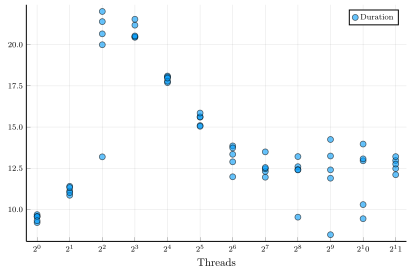

In [12]:
plot_results(results.threads,
    results.duration,    
    "pi",
    "Duration",
    max_thread_power = 11)

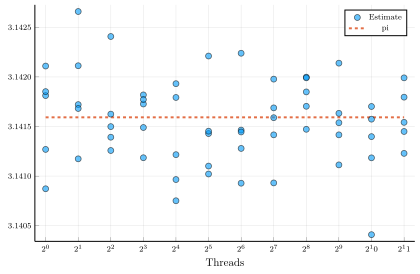

In [13]:
plot_results(results.threads,
    results.estimate,    
    "pi",
    "Estimate",
    hline = [pi for i in 1:nrow(results)],
    max_thread_power = 11)

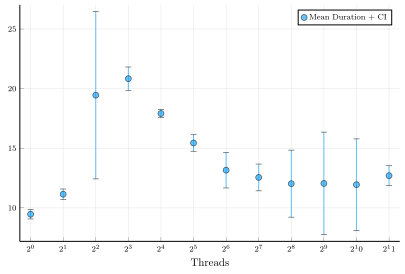

In [14]:
plot_results(parsed_results.threads,
    parsed_results.mean_duration,
    "pi",
    "Mean Duration + CI",
    yerror = parsed_results.ci_duration,
    max_thread_power = 11)

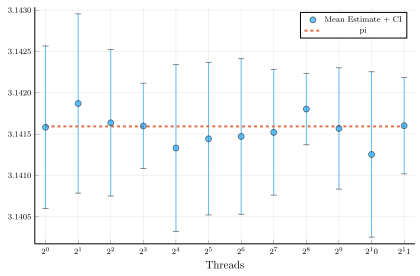

In [15]:
plot_results(parsed_results.threads,
    parsed_results.mean_estimate,
    "pi",
    "Mean Estimate + CI",
    hline = [pi for i in 1:nrow(parsed_results)],
    yerror = parsed_results.ci_estimate,
    max_thread_power = 11)